In [8]:
# !pip -q install d3rlpy==2.5.0 imbalanced-learn==0.12.4 joblib==1.4.2 plotly==5.24.1

In [9]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, warnings, joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
warnings.filterwarnings("ignore")

ACC_PATH = "/kaggle/input/lending-club-accepted-2007-to-2018/accepted_2007_to_2018Q4.csv"
REJ_PATH = "/kaggle/input/rejected-2008-to-2018/rejected_2007_to_2018Q4.csv"



In [10]:
usecols_accepted = [
    "loan_amnt","term","int_rate","installment","grade","sub_grade",
    "emp_length","home_ownership","annual_inc","verification_status",
    "issue_d","purpose","addr_state","dti","delinq_2yrs","fico_range_low","fico_range_high",
    "inq_last_6mths","open_acc","pub_rec","revol_bal","revol_util",
    "total_acc","application_type","loan_status"
]

acc = pd.read_csv(ACC_PATH, usecols=usecols_accepted, low_memory=False, nrows=500_000)
print(acc.shape)
acc.head()


(500000, 25)


,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,...,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,application_type
0,3600.0,36 months,13.99,123.03,C,C4,10+ years,MORTGAGE,55000.0,Not Verified,...,0.0,675.0,679.0,1.0,7.0,0.0,2765.0,29.7,13.0,Individual
1,24700.0,36 months,11.99,820.28,C,C1,10+ years,MORTGAGE,65000.0,Not Verified,...,1.0,715.0,719.0,4.0,22.0,0.0,21470.0,19.2,38.0,Individual
2,20000.0,60 months,10.78,432.66,B,B4,10+ years,MORTGAGE,63000.0,Not Verified,...,0.0,695.0,699.0,0.0,6.0,0.0,7869.0,56.2,18.0,Joint App
3,35000.0,60 months,14.85,829.90,C,C5,10+ years,MORTGAGE,110000.0,Source Verified,...,0.0,785.0,789.0,0.0,13.0,0.0,7802.0,11.6,17.0,Individual
4,10400.0,60 months,22.45,289.91,F,F1,3 years,MORTGAGE,104433.0,Source Verified,...,1.0,695.0,699.0,3.0,12.0,0.0,21929.0,64.5,35.0,Individual


In [11]:
default_labels = ["Charged Off","Default","Late (31-120 days)","Does not meet the credit policy. Status:Charged Off"]
paid_labels = ["Fully Paid","Does not meet the credit policy. Status:Fully Paid"]

acc = acc[acc["loan_status"].isin(default_labels + paid_labels)].copy()
acc["target"] = np.where(acc["loan_status"].isin(default_labels), 1, 0)
acc["target"].value_counts(normalize=True)


target
0    0.792449
1    0.207551
Name: proportion, dtype: float64

In [12]:
acc["fico_mid"] = (acc["fico_range_low"] + acc["fico_range_high"]) / 2
acc["issue_d"] = pd.to_datetime(acc["issue_d"], format="%b-%Y")
acc["issue_year"] = acc["issue_d"].dt.year

selected_cols = [
    "loan_amnt","int_rate","installment","annual_inc","dti","fico_mid",
    "delinq_2yrs","inq_last_6mths","open_acc","pub_rec","revol_bal","revol_util","total_acc",
    "term","grade","emp_length","home_ownership","verification_status","purpose","application_type","addr_state","issue_year"
]

df = acc[selected_cols + ["target"]].copy()
df.head()


,loan_amnt,int_rate,installment,annual_inc,dti,fico_mid,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,...,term,grade,emp_length,home_ownership,verification_status,purpose,application_type,addr_state,issue_year,target
0,3600.0,13.99,123.03,55000.0,5.91,677.0,0.0,1.0,7.0,0.0,...,36 months,C,10+ years,MORTGAGE,Not Verified,debt_consolidation,Individual,PA,2015,0
1,24700.0,11.99,820.28,65000.0,16.06,717.0,1.0,4.0,22.0,0.0,...,36 months,C,10+ years,MORTGAGE,Not Verified,small_business,Individual,SD,2015,0
2,20000.0,10.78,432.66,63000.0,10.78,697.0,0.0,0.0,6.0,0.0,...,60 months,B,10+ years,MORTGAGE,Not Verified,home_improvement,Joint App,IL,2015,0
4,10400.0,22.45,289.91,104433.0,25.37,697.0,1.0,3.0,12.0,0.0,...,60 months,F,3 years,MORTGAGE,Source Verified,major_purchase,Individual,PA,2015,0
5,11950.0,13.44,405.18,34000.0,10.20,692.0,0.0,0.0,5.0,0.0,...,36 months,C,4 years,RENT,Source Verified,debt_consolidation,Individual,GA,2015,0


Clean and preprocess

In [13]:
# Separate numeric and categorical columns
num_cols = df.select_dtypes(include=["float64","int64"]).columns.tolist()
num_cols.remove("target")  # exclude target
cat_cols = [c for c in df.columns if c not in num_cols + ["target"]]

num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", cat_pipe, cat_cols)
])

X = df.drop("target", axis=1)
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

preprocessor.fit(X_train)
joblib.dump(preprocessor, "/kaggle/working/preprocessor.joblib")
print("Preprocessor saved ")


Preprocessor saved 


EDA visuals

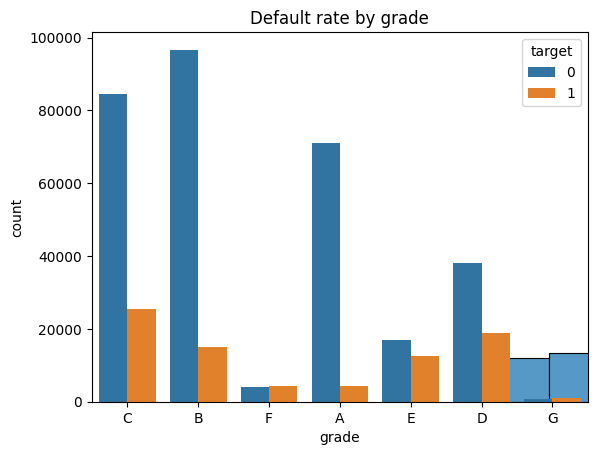

In [14]:
sns.histplot(df["int_rate"], bins=40)
plt.title("Interest rate distribution")

sns.countplot(x="grade", hue="target", data=df)
plt.title("Default rate by grade")
plt.show()
